# Trabajo práctico 2 - Organización de datos
### Facultad de ingeniería - Universidad de Buenos Aires


---


Alumna: Agustina Bocaccio \\
Padron: 106393 \\
Email: abocaccio@fi.uba.ar \\

---

#### Segundo cuatrimestre 2021
#### Fecha de entrega: 1/11

## Imports 

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt update
!apt install openjdk-8-jdk-headless -qq
#!apt install default-jre
#!apt install default-jdk
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 281.3 MB 37 kB/s 
     |████████████████████████████████| 198 kB 56.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=647bd896099e2497bcfde659997bb50aba193ac8ab950badb4d74161583e546c
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release 

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql import SQLContext
import pandas as pd
import pyspark
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

## 16) 10 categorías que tienen la menor cantidad de contenido anónimo publicado.

In [ ]:
contents = spark.read.format("csv").option("header", True).load('gdrive/My Drive/Organización de datos/Wikipedia dataset 2c2021.zip (Unzipped Files)/contents.csv')
rdd_contents = contents.rdd

In [ ]:
categories = spark.read.format("csv").option("header", True).load('gdrive/My Drive/Organización de datos/Wikipedia dataset 2c2021.zip (Unzipped Files)/categorylinks.csv')
rdd_categories = categories.rdd

De contents encuentro los usuarios que son anonimos, esto es, los usuarios que no tienen id ni username. Despues me quedo solo con los ids del contenido que haya quedado despues del filtrado

In [ ]:
anonymous_contents = rdd_contents.filter(lambda x: x.revisor_id == None and x.revisor_username==None).map(lambda x: (x.id, 1)).cache()
anonymous_contents.count()

193755

Filtro el rdd de categories y me quedo con las categorias y contenidos que no son nulos. Posteriormente, hago la interseccion de este rdd con el que tiene los ids de los usuarios anonimos para quedarme solo con las categorias y contenidos creados por usuarios anonimos.

In [ ]:
contents_and_categories = rdd_categories.filter(lambda x: x.cl_from != None and x.cl_to != None).map(lambda x: (x.cl_from, x.cl_to))
categories_and_contents_by_anonymous_users = contents_and_categories.join(anonymous_contents).cache()

Tomo las 10 categorias con menor cantidad de contenido anonimo publicado:

In [ ]:
categories_anonymous_contents = categories_and_contents_by_anonymous_users.map(lambda x: (x[1][0], x[1][1])).reduceByKey(lambda x, y: x+y).takeOrdered(10, lambda x: +x[1])
categories_anonymous_contents

[('PÃ\xado_X', 1),
 ('Objetos_astronÃ³micos_descubiertos_por_Eleanor_F._Helin', 1),
 ('Localidades_de_Guam', 1),
 ('Teseo', 1),
 ('Reus', 1),
 ('Troya', 1),
 ('TurquÃ\xada_en_1996', 1),
 ('Tratados_de_HungrÃ\xada_del_siglo_XX', 1),
 ('Tratados_de_Polonia_del_siglo_XX', 1),
 ('Tratados_de_Suecia_del_siglo_XX', 1)]

## 23) Cantidad total de contenidos por tipo de locación que pertenecen a la tierra.

In [ ]:
sqlContext = SQLContext(sc)
geo_tags = spark.read.format("csv").option("header", True).load('gdrive/My Drive/Organización de datos/Wikipedia dataset 2c2021.zip (Unzipped Files)/geo_tags.csv')
rdd_geo = geo_tags.rdd

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


Me quedo con los contenidos que pertenecen a la tierra y no tienen locacion nula. Despues saco las locaciones e ids que se repitan para no contar el mismo par (contenido, locacion) mas de una vez y por ultimo cuento por locacion la cantidad de contenidos.

In [ ]:
locations_earth = rdd_geo.filter(lambda x: x.gt_globe == 'earth' and x.gt_type != None).map(lambda x: (x.gt_type, x.gt_page_id)).distinct()\
                    .map(lambda x: (x[0], 1)).reduceByKey(lambda x,y: x+y)
locations_earth.collect()

[('landmark', 65032),
 ('airport', 3592),
 ('adm2nd', 275),
 ('forrest', 9561),
 ('glacier', 266),
 ('edu', 3133),
 ('adm1st', 153),
 ('railwaystation', 10644),
 ('country', 1703),
 ('state', 7),
 ('event', 5119),
 ('pass', 10),
 ('region', 11),
 ('landscape', 29),
 ('isle(120', 1),
 ('type:landmark', 1),
 ('nunatak', 1),
 ('tain', 1),
 ('bridge', 1135),
 ('region:us', 184),
 ('title', 3),
 ('montaña', 1),
 ('adm2', 4),
 ('mountain/it-bz/it-bl', 1),
 ('mountain/it-bl', 1),
 ('monument', 1),
 ('mosque', 1),
 ('señal', 1),
 ('waterbodyy', 1),
 ('satellite', 1),
 ('buildings', 1),
 ('site', 1),
 ('mountain', 2295),
 ('waterbody', 389),
 ('city', 251865),
 ('building', 32),
 ('adm3rd', 268),
 ('isle', 5743),
 ('forest', 15),
 ('river', 113),
 ('reef', 1),
 ('tunnel', 1),
 ('port', 2),
 ('reservoir', 1),
 ('landmarkl', 4),
 ('landmarkc', 1),
 ('landmarka', 1),
 ('lago', 2),
 ('embalse', 1),
 ('place', 1),
 ('isle(1063', 1),
 ('organization', 3),
 ('town', 3),
 ('location', 1),
 ('island', 8

## 27) La probabilidad de que la versión actual de un contenido fuera editada sin dejar comentario para usuarios que están logueados y que no están logueados

Contents tiene toda la informacion de los contenidos de wikipedia en su version mas reciente, incluyendo las revisiones de cada una

In [ ]:
contents = spark.read.format("csv").option("header", True).load('gdrive/My Drive/Organización de datos/Wikipedia dataset 2c2021.zip (Unzipped Files)/contents.csv')
rdd_contents = contents.rdd

Si no aparece el ip (es None) o tiene username es porque esta registrado

In [ ]:
contents_no_comment = rdd_contents.filter(lambda x: x.revisor_comment == None).map(lambda x: (x.revisor_ip==None or x.revisor_username!= None)).cache()

In [ ]:
non_commented_revisions_by_logged_users = contents_no_comment.countByValue()  
non_commented_revisions_by_logged_users

defaultdict(int, {False: 77075, True: 392669})

In [ ]:
no_comment_revisions_total = contents_no_comment.count()

In [ ]:
print("Probabilidad de que la versión actual de un contenido fuera editada sin dejar comentario para usuarios que están logueados:",  (non_commented_revisions_by_logged_users[True]/no_comment_revisions_total))
print("Probabilidad de que la versión actual de un contenido fuera editada sin dejar comentario para usuarios que no están logueados:", (non_commented_revisions_by_logged_users[False]/no_comment_revisions_total))

Probabilidad de que la versión actual de un contenido fuera editada sin dejar comentario para usuarios que están logueados: 0.8359212677543513
Probabilidad de que la versión actual de un contenido fuera editada sin dejar comentario para usuarios que no están logueados: 0.1640787322456487


## 39) ¿Cuál es la acción más realizada por usuarios que no están registrados? 

In [ ]:
logs = spark.read.format("csv").option("header", True).load('gdrive/My Drive/Organización de datos/Wikipedia dataset 2c2021.zip (Unzipped Files)/logs.csv')
rdd_logs = logs.rdd

Me quedo con los usuarios que no estan registrados y no tienen accion nula

In [ ]:
actions_by_non_registered_users = rdd_logs.filter(lambda x: x.contributor_ip != None and x.action!=None and x.contributor_username==None)

Agrupo por accion, las cuento y me quedo con la que mas se repite 

In [ ]:
amount_actions_by_non_registered_users= actions_by_non_registered_users.map(lambda x: (x.action,1)).reduceByKey(lambda x,y: x+y).cache()
amount_actions_by_non_registered_users.takeOrdered(1, key=lambda x: -x[1])

[('create', 123293)]

## 20) Cantidad de Stubs por categoría en la Wikipedia.

_"AutoWikiBrowser is frequently set to automatically remove stub tags from any article with more than 500 words"_


Contar las palabras de los textos y determinar si ese texto es un stub (es un stub si tiene menos de 500 palabras)

In [ ]:
texts = spark.read.format("csv").option("header", True).load('gdrive/My Drive/Organización de datos/Wikipedia dataset 2c2021.zip (Unzipped Files)/contents_text_sample.csv')
rdd_texts = texts.rdd

categories = spark.read.format("csv").option("header", True).load('gdrive/My Drive/Organización de datos/Wikipedia dataset 2c2021.zip (Unzipped Files)/categorylinks.csv')
rdd_categories = categories.rdd

In [ ]:
stubs = rdd_texts.filter(lambda x: x.text != None).map(lambda x: (x.id, x.text.split())).filter(lambda x: len(x[1])<500 and x[0]!= None).cache()
stubs.take(5)

[('50', ['{{Ficha', 'de', 'taxón']),
 ("'''Anacardiaceae''' es una [[familia (biología)|familia]] de [[Plantae|plantas]] esencialmente [[árbol|arbóreas]] y [[arbusto|arbustivas]] perteneciente al [[Orden (biología)|orden]] [[Sapindales]]. La constituyen 77 [[género (biología)|géneros]] con unas 700 especies aceptadas",
  ['propias', 'de', 'países', 'tropicales']),
 ('Son árboles', ['raramente', 'subarbustos', 'o', '[[trepadora]]s']),
 ("'''Anacardiaceae''' fue descrita por [[Robert Brown]] y publicado en ''[[Narrative of an Expedition to Explore the River Zaire]]''",
  ['1818.<ref',
   'name',
   '=',
   'Trop>{{cita',
   'web',
   '|url=http://www.tropicos.org/Name/42000260',
   '|título=',
   'Anacardiaceae|fechaacceso=13',
   'de',
   'julio',
   'de',
   '2013',
   '|obra=',
   'Tropicos.org.',
   '[[Missouri',
   'Botanical',
   'Garden]]}}</ref>']),
 ('* Blepharocaryaceae', ['Julianiaceae'])]

In [ ]:
categories_and_id = rdd_categories.map(lambda x: (x.cl_from, x.cl_to))
stubs_and_categories = stubs.join(categories_and_id).map(lambda x: (x[1][1], 1)).reduceByKey(lambda x, y: x+y)
stubs_and_categories.collect()

[('TÃ©rminos_botÃ¡nicos', 22),
 ('Flora_de_LÃ\xadbano', 3),
 ('Flora_de_Siria', 2),
 ('Nueces_y_semillas_oleaginosas', 4),
 ('Buses_seriales', 3),
 ('Wikipedia:ArtÃ\xadculos_con_identificadores_SNAC', 1927),
 ('Wikipedia:ArtÃ\xadculos_con_pasajes_que_requieren_referencias', 2101),
 ('Mezzosopranos_de_EspaÃ±a', 2),
 ('Personajes_citados_en_la_Divina_Comedia', 8),
 ('Santos_de_Macedonia', 1),
 ('Santos_de_la_Iglesia_ortodoxa', 29),
 ('Wikipedia:ArtÃ\xadculos_destacados_en_la_Wikipedia_en_chino', 21),
 ('Escritores_en_inglÃ©s_del_siglo_XX', 95),
 ('Objetos_astronÃ³micos_descubiertos_desde_el_Observatorio_Palomar', 57),
 ('Wikipedia:ArtÃ\xadculos_con_identificadores_COAM_persona', 18),
 ('Salud_del_varÃ³n', 5),
 ('Manuscrito_Voynich', 1),
 ('Grupos_de_rock_de_Suecia', 9),
 ('Batallas_en_Ã\x81lava', 4),
 ('Inframundo_griego', 5),
 ('Localidades_de_la_Provincia_Occidental_del_Cabo', 3),
 ('Protocolos_de_Internet', 5),
 ('Arquitectos_de_Granada', 2),
 ('PelÃ\xadculas_de_2005', 28),
 ('Ruido',

## 25) Obtenga con spark los datos (de forma ya agregada) que le permitan realizar la siguiente visualización y realice la misma

<img src= "https://drive.google.com/uc?id=1_kxX9qFwo6zBa3lp3p_mDYG16L4Y5VCE" width="65%">

In [ ]:
logs = spark.read.format("csv").option("header", True).load('gdrive/My Drive/Organización de datos/Wikipedia dataset 2c2021.zip (Unzipped Files)/logs.csv')
rdd_logs = logs.rdd

Me quedo con los usuarios registrados (esta registrado tiene id y username). Despues me quedo con las acciones seleccionadas para hacer el heatmap y me quedo con la accion y el usuario que la realizo

In [ ]:
actions_by_registered_users = rdd_logs.filter(lambda x: x.action!=None and x.contributor_username!=None and x.contributor_id!=None)

def is_selected_action(action): 
  selected_actions = ['move', 'delete', 'create', 'block', 'autocreate']
  if(action in selected_actions):
      return True
  return False

selected_actions_registered_users = actions_by_registered_users.filter(lambda x: is_selected_action(x.action)).map(lambda x: ((x.action, x.contributor_username), 1)).cache()

De este rdd obtengo la cantidad total de usuarios: 

In [ ]:
total_users= selected_actions_registered_users.count()

Cuento el total por tuplas (accion, username) para tener la cantidad de esa accion que realizo ese usuario

In [ ]:
amount_actions_users = selected_actions_registered_users.reduceByKey(lambda x, y: x+y).map(lambda x: (x[0][1], list((x[0][0], x[1]))))
amount_actions_users.take(20)

[('ManuelGR', ['delete', 295]),
 ('Ecemaml', ['move', 3473]),
 ('Hugo López', ['move', 34]),
 ('Xenoforme', ['move', 37]),
 ('¡Willy En Las Ruedas!', ['move', 2]),
 ('Gcsantiago', ['move', 7]),
 ('Pino', ['move', 6]),
 ('Augusto maguina', ['move', 44]),
 ('NANCY ARELLANO', ['move', 1]),
 ('Ranshao', ['move', 1]),
 ('Arístides Herrera Cuntti', ['move', 162]),
 ('Tano4595', ['move', 1748]),
 ('Tatu~eswiki', ['move', 1]),
 ('Afrox', ['move', 51]),
 ('Ejmeza', ['block', 60]),
 ('Proximo.xv', ['move', 18]),
 ('Alhen', ['move', 428]),
 ('Robotkarel', ['move', 5]),
 ('Porao', ['move', 107]),
 ('Xuankar', ['move', 54])]

Obtengo promedio de cada accion:

In [ ]:
average_actions= selected_actions_registered_users.map(lambda x: (x[0][0], 1)).reduceByKey(lambda x, y: x+y).map(lambda x: list((x[0], x[1]/total_users))).collect()
average_actions

[['autocreate', 0.12563746956180938],
 ['block', 0.03141129487481907],
 ['create', 0.5449416844194096],
 ['move', 0.0786547627679777],
 ['delete', 0.21935478837598427]]

Me guardo los promedios en constantes

In [ ]:
av_autocreate = average_actions[0][1]
av_block = average_actions[1][1]
av_create = average_actions[2][1]
av_move = average_actions[3][1]
av_delete = average_actions[4][1]

Agrupo por usuario y obtengo un rdd que tiene en cada registro una tupla con  la cantidad de accion menos promedio para cada accion de un usuario.

In [ ]:
def get_action_user(actions, action_name, average_action):
  for a in actions:
    if(a[0]==action_name):
      return (a[1]- average_action)
  return (0-average_action)


new_amount_actions_users = amount_actions_users.groupByKey().map(lambda x:  (get_action_user(x[1], 'move', av_move),  get_action_user(x[1], 'delete', av_delete), get_action_user(x[1],'create', av_create), get_action_user(x[1], 'block', av_block),  get_action_user(x[1], 'autocreate', av_autocreate))).cache()
new_amount_actions_users.take(20)

[(3472.921345237232,
  6963.780645211624,
  -0.5449416844194096,
  1372.9685887051253,
  -0.12563746956180938),
 (36.921345237232025,
  190.780645211624,
  -0.5449416844194096,
  14.968588705125182,
  -0.12563746956180938),
 (50.921345237232025,
  -0.21935478837598427,
  0.4550583155805904,
  -0.03141129487481907,
  -0.12563746956180938),
 (4.921345237232022,
  -0.21935478837598427,
  0.4550583155805904,
  -0.03141129487481907,
  -0.12563746956180938),
 (375.921345237232,
  1987.780645211624,
  -0.5449416844194096,
  586.9685887051252,
  -0.12563746956180938),
 (4.921345237232022,
  -0.21935478837598427,
  -0.5449416844194096,
  -0.03141129487481907,
  -0.12563746956180938),
 (20.92134523723202,
  -0.21935478837598427,
  -0.5449416844194096,
  -0.03141129487481907,
  -0.12563746956180938),
 (7.921345237232022,
  -0.21935478837598427,
  1.4550583155805903,
  -0.03141129487481907,
  -0.12563746956180938),
 (1.9213452372320223,
  -0.21935478837598427,
  -0.5449416844194096,
  -0.031411294

Me guardo las posiciones de los valores para cada accion:

In [ ]:
move = 0 
delete = 1
create = 2
block = 3
autocreate = 4

Hago la funcion de correlacion entre dos acciones, recibe el rdd y la posicion de la cantidad-promedio de las acciones a analizar

In [ ]:
import numpy as np

def correlation(rdd_actions, pos_action1, pos_action2):
  dividend = rdd_actions.map(lambda x: x[pos_action1]*x[pos_action2]).reduce(lambda a,b: a+b)

  sums_divider = rdd_actions.map(lambda x: x[pos_action1]*x[pos_action1]).reduce(lambda a,b: a+b) * rdd_actions.map(lambda x: x[pos_action2]*x[pos_action2]).reduce(lambda a,b: a+b) 
  divider = np.sqrt(sums_divider)

  return dividend/divider

Pruebo que para la misma accion la correlacion de 1, y que cambiando el orden de las acciones me de lo mismo: 

In [ ]:
move_move =  correlation(new_amount_actions_users, move, move)
move_move

1.0

In [ ]:
move_delete= correlation(new_amount_actions_users, delete, move)
delete_move= correlation(new_amount_actions_users, move, delete)

move_delete, delete_move

(0.08347055219905994, 0.08347055219905994)

Obtengo todas las correlaciones que necesito entre acciones: 

In [ ]:
delete_move= correlation(new_amount_actions_users, move, delete)
block_move= correlation(new_amount_actions_users, move, block)
create_move= correlation(new_amount_actions_users, move, create)
create_autocreate =  correlation(new_amount_actions_users, create, autocreate)
move_autocreate =  correlation(new_amount_actions_users, move, autocreate)
delete_autocreate = correlation(new_amount_actions_users, autocreate, delete)
delete_create = correlation(new_amount_actions_users, create, delete)
block_delete =  correlation(new_amount_actions_users, block, delete)
block_create =  correlation(new_amount_actions_users, block, create)
block_autocreate =  correlation(new_amount_actions_users, block, autocreate)

Acomodo los valores en una matriz para poder graficar, pongo 1 en los lugares en los que se analiza la correlacion entre una accion y si misma, ya que como se vio mas arriba y como se ve en el heatmap del enunciado, da 1

In [ ]:
correlations = [[1.0, block_autocreate, create_autocreate, delete_autocreate, move_autocreate],
             [block_autocreate, 1.0, block_create, block_delete, block_move],
             [create_autocreate, block_create, 1.0, delete_create, create_move], 
             [delete_autocreate, block_delete, delete_create, 1.0, delete_move],
             [move_autocreate, block_move, create_move, delete_move, 1.0]]

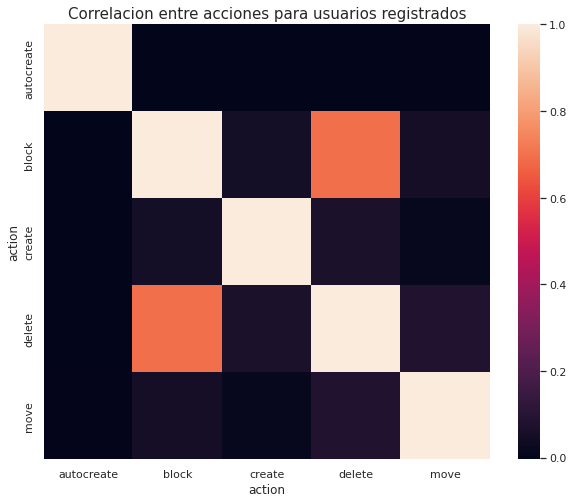

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(10,8)})

labels = ['autocreate', 'block', 'create', 'delete', 'move'] 
g = sns.heatmap(correlations, cmap="rocket", fmt='f' , xticklabels=labels, yticklabels=labels)
g.set_ylabel("action")
g.set_xlabel("action")
g.set_title("Correlacion entre acciones para usuarios registrados", size=15)
plt.show()